In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, style='whitegrid', palette=palette)  # 解决Seaborn中文显示问题

In [2]:
场地处理能力df = pd.read_excel('../../../preprocess/场地处理能力.xlsx')
场地处理能力df.set_index('场地', inplace=True)
线路运输能力df = pd.read_excel('../../../preprocess/线路运输能力.xlsx')
rawData = pd.read_excel('../../../T1/解题/时间窗口为5-第一问结果LTSM-物流网络历史货量数据.xlsx')
rawDataMelt = pd.melt(pd.merge(rawData.iloc[:, :2], rawData.iloc[:, -31:], left_index=True, right_index=True),
                      id_vars=['场地1', '场地2'], value_name='货量', var_name='日期')
totalEdgeLen = len(rawData)
print(f'总线路数量：{totalEdgeLen}')
print(rawDataMelt.dtypes)
rawDataMelt

总线路数量：1049
场地1     int64
场地2     int64
日期     object
货量      int64
dtype: object


,场地1,场地2,日期,货量
0,1,8,2023-01-01,3
1,2,3,2023-01-01,1
2,2,4,2023-01-01,2
3,2,5,2023-01-01,10
4,2,8,2023-01-01,2
...,...,...,...,...
32514,76,8,2023-01-31,15
32515,76,10,2023-01-31,13
32516,76,14,2023-01-31,1
32517,76,62,2023-01-31,4


In [3]:
全年线路负载率df = pd.read_excel('../全年线路负载率df.xlsx')
全年线路负载率df = 全年线路负载率df.set_index(['场地1', '场地2'])
全年线路负载率df

货量       负载率
场地1 场地2                    
1   8    3.040736  0.001388
2   3    6.353482  0.001336
    4    9.684625  0.001335
    5    5.281209  0.001391
    8    2.241787  0.001398
...           ...       ...
76  8    4.187911  0.001434
    10   3.540079  0.001442
    14   1.584757  0.001349
    62   1.977661  0.001384
77  6    2.067017  0.001416

[1049 rows x 2 columns]

In [4]:
线路运输能力df = 线路运输能力df.set_index(['场地1', '场地2'])
线路运输能力df


货量
场地1 场地2      
1   8    2190
2   3    4756
    4    7252
    5    3797
    8    1604
...       ...
76  8    2920
    10   2455
    14   1175
    62   1429
77  6    1460

[1049 rows x 1 columns]

In [5]:
# 与DC5相关的线路
向dc5发货的场地 = rawData[(rawData['场地2'] == 5)]['场地1']
print(f'发送货物到DC5的路线数量：{len(向dc5发货的场地)}')
向dc5发货的场地

发送货物到DC5的路线数量：67


3        2
10       3
27       4
79       7
93       8
        ..
999     71
1011    72
1020    73
1035    74
1043    76
Name: 场地1, Length: 67, dtype: int64

In [6]:
rawData

,场地1,场地2,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,...,2023-01-22,2023-01-23,2023-01-24,2023-01-25,2023-01-26,2023-01-27,2023-01-28,2023-01-29,2023-01-30,2023-01-31
0,1,8,3,3,3,3,3,3,3,3,...,4,4,4,4,5,5,5,5,5,5
1,2,3,9,9,9,9,9,9,9,9,...,3,4,4,4,4,4,4,4,4,4
2,2,4,2,2,2,2,2,2,2,2,...,4,4,5,5,5,5,5,5,5,5
3,2,5,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,5
4,2,8,2,2,2,2,2,2,2,2,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,76,8,4,4,4,4,4,4,4,4,...,11,11,12,12,13,13,14,14,15,15
1045,76,10,3,3,3,3,3,3,3,3,...,9,10,10,11,11,12,12,13,13,13
1046,76,14,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
1047,76,62,2,2,2,2,2,2,2,2,...,3,3,3,3,3,3,4,4,4,4


In [7]:
'''
1. 找出DC5上游发货节点
2. 找出每个发货节点中负载率最大的线路，把原应发往DC5的货发往该线路
3. 画出2023年图像
'''

线路变化后的df = rawData.copy().set_index(['场地1', '场地2'])
仅仅线路变化的df = pd.DataFrame()
for 上游节点 in 向dc5发货的场地:
    上游节点发货线路 = rawData[rawData['场地1'] == 上游节点].copy()
    上游线路idx = 上游节点发货线路.set_index(['场地1', '场地2']).index
    上游节点发货负载最大的线路tuple = \
        全年线路负载率df[全年线路负载率df.index.isin(上游线路idx)].sort_values(['负载率'], ascending=False).index[0]
    上游节点发货负载最大的线路df = rawData[(rawData['场地1'] == 上游节点发货负载最大的线路tuple[0]) & (
            rawData['场地2'] == 上游节点发货负载最大的线路tuple[1])].reset_index(drop=True)

    原本应该发往DC5的货量df = rawData[(rawData['场地1'] == 上游节点) & (rawData['场地2'] == 5)].reset_index(drop=True)

    叠加后df = 上游节点发货负载最大的线路df.iloc[:, 2:] + 原本应该发往DC5的货量df.iloc[:, 2:]
    print(上游节点发货负载最大的线路tuple)
    叠加后df.insert(0, '场地2', 上游节点发货负载最大的线路tuple[1])
    叠加后df.insert(0, '场地1', 上游节点发货负载最大的线路tuple[0])
    叠加后df = 叠加后df.set_index(['场地1', '场地2'])
    线路变化后的df.loc[上游节点发货负载最大的线路tuple] = 叠加后df.loc[上游节点发货负载最大的线路tuple]
    # break
    仅仅线路变化的df = pd.concat([仅仅线路变化的df, 叠加后df.reset_index()])

线路变化后的df = 线路变化后的df.reset_index()
线路变化后的df

(2, 10)
(3, 12)
(4, 23)
(7, 4)
(8, 5)
(9, 36)
(10, 23)
(11, 22)
(12, 5)
(13, 5)
(14, 17)
(15, 64)
(16, 10)
(17, 64)
(19, 12)
(20, 64)
(21, 34)
(22, 32)
(23, 64)
(24, 4)
(25, 34)
(26, 14)
(27, 14)
(28, 14)
(30, 65)
(31, 5)
(33, 65)
(34, 8)
(35, 62)
(36, 64)
(37, 54)
(38, 65)
(39, 4)
(40, 67)
(41, 3)
(42, 65)
(43, 64)
(44, 64)
(45, 81)
(46, 65)
(47, 64)
(48, 65)
(49, 9)
(50, 65)
(51, 64)
(52, 65)
(53, 5)
(55, 35)
(56, 61)
(57, 5)
(58, 34)
(59, 14)
(60, 5)
(61, 4)
(62, 5)
(64, 4)
(65, 62)
(66, 5)
(67, 3)
(68, 64)
(69, 8)
(70, 38)
(71, 12)
(72, 9)
(73, 64)
(74, 8)
(76, 3)


,场地1,场地2,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,...,2023-01-22,2023-01-23,2023-01-24,2023-01-25,2023-01-26,2023-01-27,2023-01-28,2023-01-29,2023-01-30,2023-01-31
0,1,8,3,3,3,3,3,3,3,3,...,4,4,4,4,5,5,5,5,5,5
1,2,3,9,9,9,9,9,9,9,9,...,3,4,4,4,4,4,4,4,4,4
2,2,4,2,2,2,2,2,2,2,2,...,4,4,5,5,5,5,5,5,5,5
3,2,5,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,5
4,2,8,2,2,2,2,2,2,2,2,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,76,8,4,4,4,4,4,4,4,4,...,11,11,12,12,13,13,14,14,15,15
1045,76,10,3,3,3,3,3,3,3,3,...,9,10,10,11,11,12,12,13,13,13
1046,76,14,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
1047,76,62,2,2,2,2,2,2,2,2,...,3,3,3,3,3,3,4,4,4,4


In [8]:
仅仅线路变化的df

,场地1,场地2,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,...,2023-01-22,2023-01-23,2023-01-24,2023-01-25,2023-01-26,2023-01-27,2023-01-28,2023-01-29,2023-01-30,2023-01-31
0,2,10,8,8,8,8,8,8,8,8,...,40,41,42,43,44,44,45,46,46,46
0,3,12,5,19,7,9,3,5,13,15,...,48,49,50,51,51,52,52,53,53,53
0,4,23,4,4,4,4,4,4,4,4,...,8217,8311,8383,8444,8498,8543,8586,8611,8646,8660
0,7,4,204,492,383,985,910,311,317,277,...,2521,2593,2665,2738,2813,2890,2970,3052,3135,3221
0,8,5,58,58,58,58,58,58,58,58,...,25300,25494,25698,25904,26100,26300,26510,26716,26922,27126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,71,12,5617,4967,5122,2646,2594,319,203,320,...,2344,2420,2501,2584,2680,2779,2891,3010,3135,3266
0,72,9,46,46,46,46,46,46,46,46,...,178,181,184,187,190,193,196,200,203,207
0,73,64,274,274,274,274,274,274,274,274,...,6354,6653,6968,7262,7603,7956,8284,8665,9017,9369
0,74,8,5,5,5,5,5,5,5,5,...,18,19,19,20,20,21,21,23,23,24


In [57]:
仅仅线路变化的df只有2023 = 仅仅线路变化的df.set_index(['场地1', '场地2']).iloc[:, -31:].reset_index()
仅仅线路变化的df只有2023.T.to_excel('仅仅线路变化的df只有2023.T.xlsx')
仅仅线路变化的df只有2023.to_excel('仅仅线路变化的df只有2023.xlsx', index=False)
仅仅线路变化的df只有2023

,场地1,场地2,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,...,2023-01-22,2023-01-23,2023-01-24,2023-01-25,2023-01-26,2023-01-27,2023-01-28,2023-01-29,2023-01-30,2023-01-31
0,2,10,26,27,27,27,28,28,29,29,...,40,41,42,43,44,44,45,46,46,46
1,3,12,26,27,27,28,30,31,32,33,...,48,49,50,51,51,52,52,53,53,53
2,4,23,3862,4021,4214,4434,4677,4918,5180,5440,...,8217,8311,8383,8444,8498,8543,8586,8611,8646,8660
3,7,4,787,895,941,1038,1122,1218,1306,1398,...,2521,2593,2665,2738,2813,2890,2970,3052,3135,3221
4,8,5,20066,22054,22110,21804,21934,22302,22488,22622,...,25300,25494,25698,25904,26100,26300,26510,26716,26922,27126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,71,12,1554,1575,1594,1614,1635,1661,1683,1710,...,2344,2420,2501,2584,2680,2779,2891,3010,3135,3266
63,72,9,116,119,122,124,127,129,132,134,...,178,181,184,187,190,193,196,200,203,207
64,73,64,3188,3361,3309,3329,3452,3563,3661,3761,...,6354,6653,6968,7262,7603,7956,8284,8665,9017,9369
65,74,8,8,9,9,10,10,10,11,11,...,18,19,19,20,20,21,21,23,23,24


In [13]:
# 使用apply函数将两列合并为一列，并返回一个新的Series
new_col = 仅仅线路变化的df只有2023.apply(lambda row: '-'.join([str(row['场地1']), str(row['场地2'])]), axis=1)
# 将新的Series拼接到原始DataFrame中，并删除原来的两列
仅仅线路变化的df只有2023路线 = 仅仅线路变化的df只有2023.join(new_col.rename('路线')).drop(['场地1', '场地2'], axis=1)
# 弹出最后一列，并将其插入到最前面
last_col = 仅仅线路变化的df只有2023路线.pop('路线')
仅仅线路变化的df只有2023路线.insert(0, '路线', last_col)
仅仅线路变化的df只有2023路线

,路线,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,...,2023-01-22,2023-01-23,2023-01-24,2023-01-25,2023-01-26,2023-01-27,2023-01-28,2023-01-29,2023-01-30,2023-01-31
0,2-10,26,27,27,27,28,28,29,29,30,...,40,41,42,43,44,44,45,46,46,46
1,3-12,26,27,27,28,30,31,32,33,33,...,48,49,50,51,51,52,52,53,53,53
2,4-23,3862,4021,4214,4434,4677,4918,5180,5440,5720,...,8217,8311,8383,8444,8498,8543,8586,8611,8646,8660
3,7-4,787,895,941,1038,1122,1218,1306,1398,1489,...,2521,2593,2665,2738,2813,2890,2970,3052,3135,3221
4,8-5,20066,22054,22110,21804,21934,22302,22488,22622,22826,...,25300,25494,25698,25904,26100,26300,26510,26716,26922,27126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,71-12,1554,1575,1594,1614,1635,1661,1683,1710,1738,...,2344,2420,2501,2584,2680,2779,2891,3010,3135,3266
63,72-9,116,119,122,124,127,129,132,134,138,...,178,181,184,187,190,193,196,200,203,207
64,73-64,3188,3361,3309,3329,3452,3563,3661,3761,3867,...,6354,6653,6968,7262,7603,7956,8284,8665,9017,9369
65,74-8,8,9,9,10,10,10,11,11,12,...,18,19,19,20,20,21,21,23,23,24


In [45]:
仅仅线路变化的df只有2023路线 = 仅仅线路变化的df只有2023路线.sort_values(['2023-01-01'], ascending=False)[:5]
仅仅线路变化的df只有2023路线

,路线,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,...,2023-01-22,2023-01-23,2023-01-24,2023-01-25,2023-01-26,2023-01-27,2023-01-28,2023-01-29,2023-01-30,2023-01-31
4,8-5,20066,22054,22110,21804,21934,22302,22488,22622,22826,...,25300,25494,25698,25904,26100,26300,26510,26716,26922,27126
6,10-23,8380,8731,8766,8674,8977,9215,9453,9702,10016,...,17578,18040,18403,18732,19047,19287,19541,19758,19965,20177
2,4-23,3862,4021,4214,4434,4677,4918,5180,5440,5720,...,8217,8311,8383,8444,8498,8543,8586,8611,8646,8660
3,7-4,787,895,941,1038,1122,1218,1306,1398,1489,...,2521,2593,2665,2738,2813,2890,2970,3052,3135,3221
0,2-10,26,27,27,27,28,28,29,29,30,...,40,41,42,43,44,44,45,46,46,46


In [46]:
仅仅线路变化的df只有2023路线长表 = pd.melt(仅仅线路变化的df只有2023路线, id_vars=['路线'], value_name='货量',
                                           var_name='日期')
仅仅线路变化的df只有2023路线长表

,路线,日期,货量
0,8-5,2023-01-01,20066
1,10-23,2023-01-01,8380
2,4-23,2023-01-01,3862
3,7-4,2023-01-01,787
4,2-10,2023-01-01,26
...,...,...,...
150,8-5,2023-01-31,27126
151,10-23,2023-01-31,20177
152,4-23,2023-01-31,8660
153,7-4,2023-01-31,3221


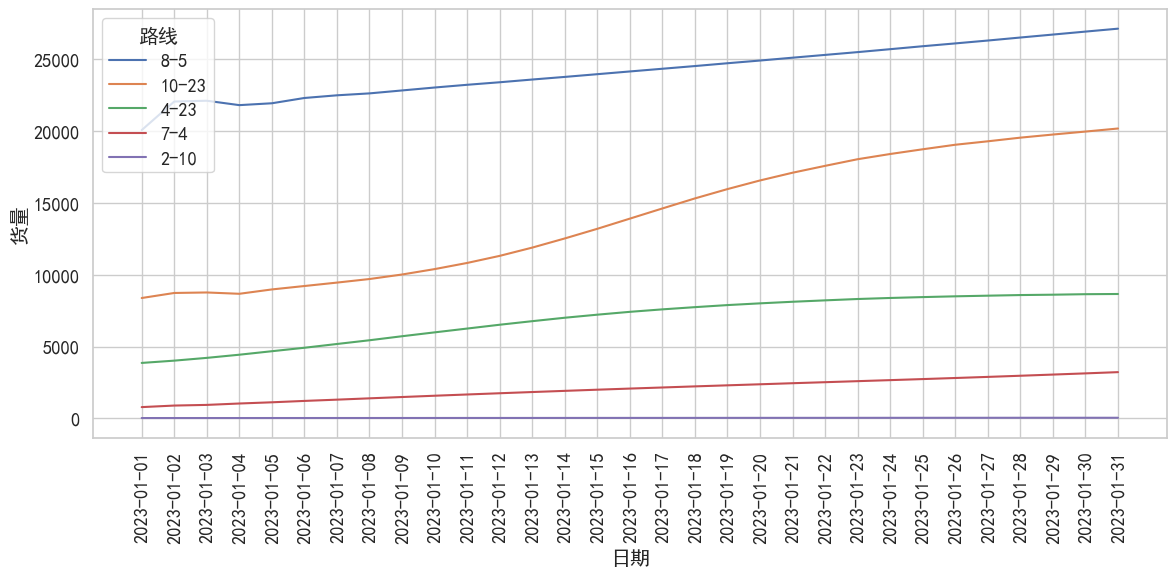

In [54]:
plt.figure(figsize=(12, 6))
sns.lineplot(仅仅线路变化的df只有2023路线长表, hue='路线', x='日期', y='货量')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('DC5关闭后线路负载增加.svg')
plt.show()